Copyright **`(c)`** 2023 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# LAB9

Write a local-search algorithm (eg. an EA) able to solve the *Problem* instances 1, 2, 5, and 10 on a 1000-loci genomes, using a minimum number of fitness calls. That's all.

### Deadlines:

* Submission: Sunday, December 3 ([CET](https://www.timeanddate.com/time/zones/cet))
* Reviews: Sunday, December 10 ([CET](https://www.timeanddate.com/time/zones/cet))

Notes:

* Reviews will be assigned  on Monday, December 4
* You need to commit in order to be selected as a reviewer (ie. better to commit an empty work than not to commit)

In [678]:
from random import choices
from dataclasses import dataclass
from copy import copy
from random import randint, random, choice
import lab9_lib
import numpy as np

In [679]:
fitness = lab9_lib.make_problem(1)

for n in range(10):
    ind = choices([0, 1], k=50)
    print(f"{''.join(str(g) for g in ind)}: {fitness(ind):.2%}")


print(fitness.calls)

01100101101001110011100101100000001010011100111101: 50.00%
00001101001111101011001110111101100101011111000100: 56.00%
00111110000110011001010101110101000100110000110000: 44.00%
11010001100011100001001101110000001010110101110111: 50.00%
11100101011010010010000111010001011100111110010111: 54.00%
00000001000001011101110010100001110111110110111001: 48.00%
01001100011010110001011100100110100111110100011010: 50.00%
01010010010010011000101000111000111101010001100010: 42.00%
00001011101110010100010111100010100001010100100101: 44.00%
01111011100101100111001101001101000110011010001110: 54.00%
10


In [680]:
POPULATION_SIZE = 300
OFFSPRING_SIZE = 300
TOURNAMENT_SIZE = 5
MUTATION_PROBABILITY = .15

SEQUENCE_LENGTH = 1000

In [681]:
@dataclass
class Individual:
    fitness: float
    genotype: list[bool]

### Selection

In [682]:
class Tournament():
    def __init__(self, size):
        self.size = size

    def select(self, pop):
        pool = [choice(pop) for _ in range(self.size)]
        champion = max(pool, key=lambda i: i.fitness)
        return champion


### Mutation

In [683]:
class BitFlip():
    def __init__(self, sequence_length):
        self.sequence_length = sequence_length
    
    def mutate(self, ind: Individual) -> Individual:
        offspring = copy(ind)
        pos = randint(0, self.sequence_length-1)
        offspring.genotype[pos] = not offspring.genotype[pos]
        offspring.fitness = None
        
        return offspring

### Recombination

In [684]:
class OnePointCrossover():
    def __init__(self, sequence_length):
        self.sequence_length = sequence_length

    def recombine(self,ind1: Individual, ind2: Individual) -> Individual:
        cut_point = randint(0, self.sequence_length-1)
        offspring = Individual(fitness=None,
                            genotype=ind1.genotype[:cut_point] + ind2.genotype[cut_point:])
        assert len(offspring.genotype) == self.sequence_length
        return offspring

In [685]:
import random

class UniformCrossover():
    def __init__(self, sequence_length):
        self.sequence_length = sequence_length

    def uniform_crossover(self,ind1: Individual, ind2: Individual, crossover_probability):

        offspring_genotype = []

        for gene_position in range(len(ind1.genotype)):
            if random.uniform(0, 1) < crossover_probability:
                offspring_genotype.append(ind2.genotype[gene_position])
            else:
                offspring_genotype.append(ind1.genotype[gene_position])
        
        offspring = Individual(fitness=None,
                        genotype=offspring_genotype)
                
        return offspring



In [686]:
class EA_Simulation():
    def __init__(self, population_size, offspring_size, fitness_eval,selection, mutation, recombination, num_gen = 600, mutation_prob = 0.35):
        self.population_size = population_size
        self.offspring_size = offspring_size
        self.fitness_eval = fitness_eval
        self.select_parent = lambda pop : selection.select(pop)
        self.mutate = lambda ind : mutation.mutate(ind)
        self.recombine = lambda ind1, ind2: recombination.uniform_crossover(ind1, ind2,0.5)
        self.num_gen = num_gen
        self.mutation_prob = mutation_prob

    def set_inital_pop(self, population):
        self.population = population

    def simulate(self, already_evaluated):
        record = []
        best_fitness = -100
        cnt = 0  #number of iterations without improving
        gen = 0

        while best_fitness < 1.0 and gen < 600:
            gen += 1
            offspring = list()
            if cnt % 25 == 0 and cnt > 0:
                self.mutation_prob = self.mutation_prob * 1.25  #if for 100 iterations there is no improvement, increase the mutation prob -> more exploration
            for _ in range(OFFSPRING_SIZE):
                p1 = self.select_parent(self.population[:])  #select the parents among the best ones
                p2 = self.select_parent(self.population[:])
                o = self.recombine(p1, p2)
                if random.random() < self.mutation_prob:
                    o = self.mutate(o)
                offspring.append(o)

            for i in offspring:  
                genotype_tuple = tuple(i.genotype)
                if already_evaluated.get(genotype_tuple) is not None: #compute the fitness just in case the offspring is not already in the population
                    i.fitness = already_evaluated.get(genotype_tuple)
                else:
                    i.fitness = fitness(i.genotype)
                    already_evaluated[genotype_tuple] = i.fitness
            
                self.population.append(i)      
            
            self.population.sort(key=lambda i: i.fitness, reverse=True)
            self.population = self.population[:self.population_size]

            if self.population[0].fitness > best_fitness:
                best_fitness = self.population[0].fitness
                #print('IMPROVEMENT')
                cnt = 0
            else:
                cnt += 1
            record.append(self.population[0].fitness)

        return record,best_fitness,fitness.calls
        

        
        

### Initialize Population

In [687]:
population = [
    Individual(
        genotype=[choice((False, True)) for _ in range(SEQUENCE_LENGTH)],
        fitness=None,
    )
    for _ in range(POPULATION_SIZE)
]

for i in population:
    i.fitness = fitness(i.genotype)

### Experiment

In [688]:
fitness = lab9_lib.make_problem(1)
selection = Tournament(size = SEQUENCE_LENGTH)
mutation = BitFlip(sequence_length= SEQUENCE_LENGTH)
recombination = UniformCrossover(sequence_length= SEQUENCE_LENGTH)
already_evaluated = {}

sim = EA_Simulation(population_size=POPULATION_SIZE, offspring_size= OFFSPRING_SIZE, fitness_eval=fitness, selection=selection, mutation=mutation, recombination=recombination)

sim.set_inital_pop(population)

record_1,best_fitness_1,fitness_calls_1 = sim.simulate(already_evaluated)
print(f'NUMBER OF FITNESS CALLS: {fitness_calls_1}, BEST FITNESS: {best_fitness_1}')

NUMBER OF FITNESS CALLS: 26660, BEST FITNESS: 1.0


In [689]:
fitness = lab9_lib.make_problem(2)
selection = Tournament(size = SEQUENCE_LENGTH)
mutation = BitFlip(sequence_length= SEQUENCE_LENGTH)
recombination = UniformCrossover(sequence_length= SEQUENCE_LENGTH)
already_evaluated = {}

sim = EA_Simulation(population_size=POPULATION_SIZE, offspring_size= OFFSPRING_SIZE, fitness_eval=fitness, selection=selection, mutation=mutation, recombination=recombination)

sim.set_inital_pop(population)

record_2,best_fitness_2,fitness_calls_2 = sim.simulate(already_evaluated)
print(f'NUMBER OF FITNESS CALLS: {fitness_calls_2}, BEST FITNESS: {best_fitness_2}')

NUMBER OF FITNESS CALLS: 2840, BEST FITNESS: 0.588


In [690]:
fitness = lab9_lib.make_problem(5)
selection = Tournament(size = SEQUENCE_LENGTH)
mutation = BitFlip(sequence_length= SEQUENCE_LENGTH)
recombination = UniformCrossover(sequence_length= SEQUENCE_LENGTH)
already_evaluated = {}

sim = EA_Simulation(population_size=POPULATION_SIZE, offspring_size= OFFSPRING_SIZE, fitness_eval=fitness, selection=selection, mutation=mutation, recombination=recombination)

sim.set_inital_pop(population)

record_5,best_fitness_5,fitness_calls_5 = sim.simulate(already_evaluated)
print(f'NUMBER OF FITNESS CALLS: {fitness_calls_5}, BEST FITNESS: {best_fitness_5}')

NUMBER OF FITNESS CALLS: 13716, BEST FITNESS: 0.58


In [691]:
fitness = lab9_lib.make_problem(10)
selection = Tournament(size = SEQUENCE_LENGTH)
mutation = BitFlip(sequence_length= SEQUENCE_LENGTH)
recombination = UniformCrossover(sequence_length= SEQUENCE_LENGTH)
already_evaluated = {}

sim = EA_Simulation(population_size=POPULATION_SIZE, offspring_size= OFFSPRING_SIZE, fitness_eval=fitness, selection=selection, mutation=mutation, recombination=recombination)

sim.set_inital_pop(population)

record_10,best_fitness_10,fitness_calls_10 = sim.simulate(already_evaluated)
print(f'NUMBER OF FITNESS CALLS: {fitness_calls_10}, BEST FITNESS: {best_fitness_10}')

NUMBER OF FITNESS CALLS: 13640, BEST FITNESS: 0.58


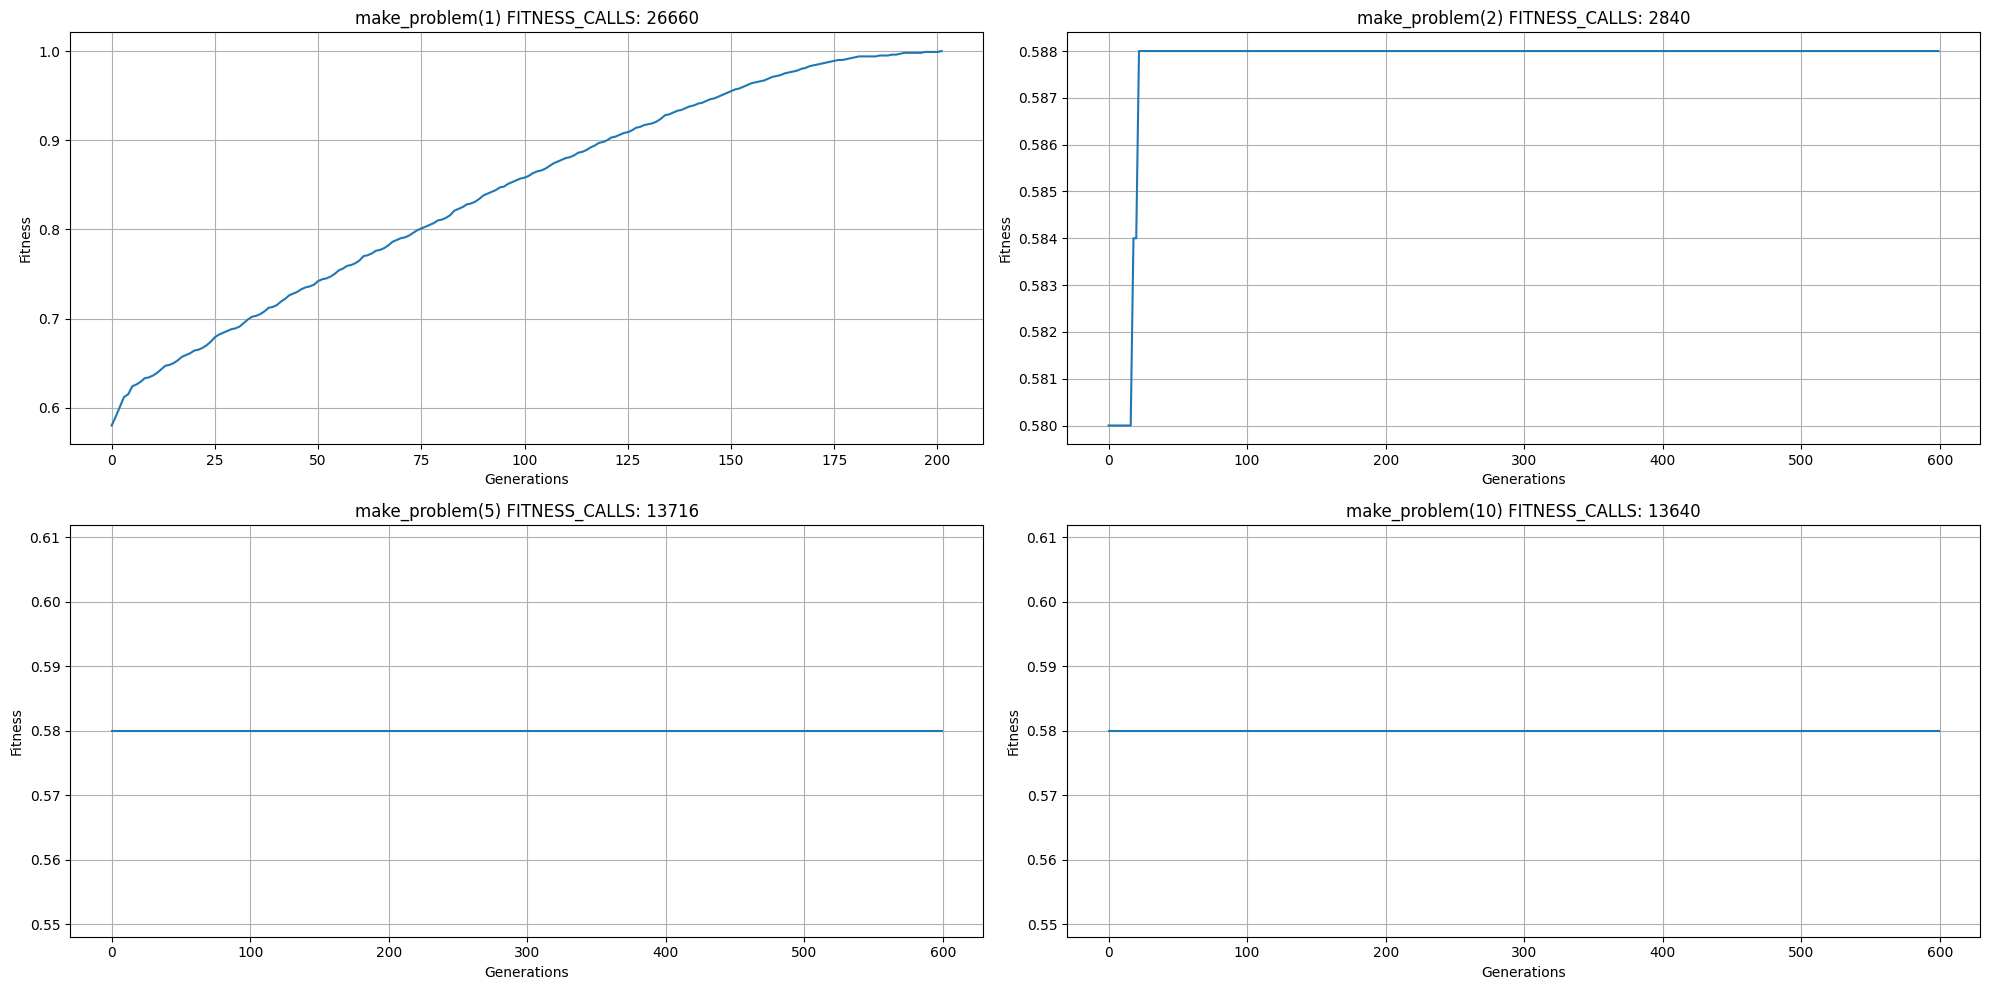

In [692]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,10))
plt.subplot(2, 2, 1)
plt.plot(np.arange(len(record_1)), record_1)
plt.title(f'make_problem(1) FITNESS_CALLS: {fitness_calls_1}')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()

plt.subplot(2, 2, 2)
plt.plot(np.arange(len(record_2)), record_2)
plt.title(f'make_problem(2) FITNESS_CALLS: {fitness_calls_2}')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()

plt.subplot(2, 2, 3)
plt.plot(np.arange(len(record_5)), record_5)
plt.title(f'make_problem(5) FITNESS_CALLS: {fitness_calls_5}')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()

plt.subplot(2, 2, 4)
plt.plot(np.arange(len(record_10)), record_10)
plt.title(f'make_problem(10) FITNESS_CALLS: {fitness_calls_10}')
plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.grid()

# Adjust layout to prevent clipping of titles
plt.tight_layout()


# Show the plots
plt.show()

